In [22]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
import scipy as sp
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import tree
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [2]:
# Load data into dataframe
df = pd.read_csv('mental-heath-in-tech-2016_20161114.csv')

In [3]:
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])

Number of rows: 1433
Number of columns: 63


In [4]:
# Check number of NaNs in each column
for col in df.columns:
    print(col, df[col].isnull().sum())

Are you self-employed? 0
How many employees does your company or organization have? 287
Is your employer primarily a tech company/organization? 287
Is your primary role within your company related to tech/IT? 1170
Does your employer provide mental health benefits as part of healthcare coverage? 287
Do you know the options for mental health care available under your employer-provided coverage? 420
Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)? 287
Does your employer offer resources to learn more about mental health concerns and options for seeking help? 287
Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer? 287
If a mental health issue prompted you to request a medical leave from work, asking for that leave would be: 287
Do you think that discussing a mental health disorder with your employer would have negati

In [5]:
# Drop rows where number of non-NaN values < 50 and drop columns where number number of non-Nan values < 600
df_cleaned = df.dropna(axis=0, thresh=50).dropna(axis=1, thresh=600)

In [7]:
print('Number of rows:', df_cleaned.shape[0])
print('Number of columns:', df_cleaned.shape[1])

Number of rows: 692
Number of columns: 48


In [8]:
# Remove columns known to be unhelpful 
del df_cleaned['Which of the following best describes your work position?']
del df_cleaned['What country do you work in?']
del df_cleaned['Why or why not?']
del df_cleaned['Why or why not?.1']
del df_cleaned['If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?']
del df_cleaned['If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?']
del df_cleaned['How willing would you be to share with friends and family that you have a mental illness?']
del df_cleaned['Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?']

print('Number of rows:', df_cleaned.shape[0])
print('Number of columns:', df_cleaned.shape[1])

Number of rows: 692
Number of columns: 40


In [9]:
# remove rows with 'maybe' in target variables in order to make this binary decision problem 
df_cleaned = df_cleaned[df_cleaned['Do you currently have a mental health disorder?'] !='Maybe']
df_cleaned = df_cleaned[df_cleaned['Have you had a mental health disorder in the past?'] != 'Maybe']

In [63]:
# SPLIT INTO X (FEATURES) AND Y
possible_y = ['Have you had a mental health disorder in the past?', 'Do you currently have a mental health disorder?', 'Have you been diagnosed with a mental health condition by a medical professional?', 'Have you ever sought treatment for a mental health issue from a mental health professional?']
y = df_cleaned[possible_y]
X = df_cleaned.drop(possible_y, axis=1)

In [64]:
# Clean up binary 
X['Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?'] = X['Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?'].map({'Yes': 1, 'No': 0})

# Convert categorial answers to numerical variables  
X = X.replace({'United States of America': 1})
X['What country do you live in?'] = X['What country do you live in?'].apply(lambda x: int(str(x).isdigit()))

# Convert if contains male or female 

male_list = ['Male', 'male', 'mail', 'M', 'Man', 'man', 'dude', 'guy']
female_list = ['Female', 'female', 'F', 'woman', 'Woman', 'girl', 'gal', 'fem']

for val in X['What is your gender?']:
    for male_name in male_list:
        if str(val).__contains__(male_name):
            X['What is your gender?'].replace(val, 'm', inplace=True)
            break
    for female_name in female_list:
        if str(val).__contains__(female_name):
            X['What is your gender?'].replace(val, 'f', inplace=True)
            break


In [12]:
# helper function 

def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [60]:
# if not int type then use one hot encoding 

features_to_encode = X.select_dtypes(['object']).columns

for feature in features_to_encode:
    X = encode_and_bind(X, feature)

In [14]:
# use one hot for y vals 
# if not int type then use one hot encoding 
# INCLUDING MAYBE

y_to_encode = y.select_dtypes(['object']).columns
y_maybe = y

for y_val in y_to_encode:
    y_maybe = encode_and_bind(y_maybe, y_val)

In [15]:
# converts y_vals to 1/0 instead of Yes/No
# REMOVING THE 'MAYBE'

y = y.replace({'Yes': 1})
y = y.replace({'No': 0})

In [61]:
# Feature selection on 0.01 variance
# uses sklearn.feature_selection

sel = VarianceThreshold(0.01)
selected_features = sel.fit_transform(X)
print(len(selected_features[0]))

111


In [ ]:
# FIRST HALF OF PROJECT: INCLUDING 'MAYBE'

In [19]:
# Check class imbalances for all possible y targets
cols = list(y_maybe)
for col in cols:
    count = 0
    for val in y_maybe[col]:
        if val == 1:
            count += 1
    print(col)
    print(count/692, '\n')

Have you ever sought treatment for a mental health issue from a mental health professional?
0.523121387283237 

Have you had a mental health disorder in the past?_No
0.18641618497109827 

Have you had a mental health disorder in the past?_Yes
0.523121387283237 

Do you currently have a mental health disorder?_No
0.21098265895953758 

Do you currently have a mental health disorder?_Yes
0.4985549132947977 

Have you been diagnosed with a mental health condition by a medical professional?_No
0.20809248554913296 

Have you been diagnosed with a mental health condition by a medical professional?_Yes
0.5014450867052023 



In [ ]:
# MODEL SELECTION (WITH MAYBE)

In [20]:
# Logistic Regression (with maybe rows)
for target in ['Have you ever sought treatment for a mental health issue from a mental health professional?', 'Have you been diagnosed with a mental health condition by a medical professional?_Yes', 'Do you currently have a mental health disorder?_Yes', 'Have you had a mental health disorder in the past?_Yes']:
    X_train, X_test, y_train, y_test = train_test_split(selected_features, y_maybe[target], test_size=0.20)
    for solver in ['lbfgs', 'liblinear']:
        for penalty in ['none', 'l1', 'l2']:
            for C in [0.5, 1.0, 5.0]:
                if (solver == 'liblinear' and penalty == 'none') or (solver == 'lbfgs' and penalty == 'l1') or (penalty == 'none' and (C == 0.5 or C == 5.0)):
                    continue # liblinear requies some sort of penalty
                logmodel = LogisticRegression(solver=solver, penalty=penalty, C=C, max_iter=1000)
                logmodel.fit(X_train,y_train)
                predictions = logmodel.predict(X_test)
                print('Target variable:', target)
                print('Solver used:', solver)
                print('Penalty used:', penalty)
                print('C (regularization parameter) used:', C)
                print('Accuracy:', accuracy_score(y_test, predictions), '\n')

Target variable: Have you ever sought treatment for a mental health issue from a mental health professional?
Solver used: lbfgs
Penalty used: none
C (regularization parameter) used: 1.0
Accuracy: 0.7676767676767676 

Target variable: Have you ever sought treatment for a mental health issue from a mental health professional?
Solver used: lbfgs
Penalty used: l2
C (regularization parameter) used: 0.5
Accuracy: 0.8181818181818182 

Target variable: Have you ever sought treatment for a mental health issue from a mental health professional?
Solver used: lbfgs
Penalty used: l2
C (regularization parameter) used: 1.0
Accuracy: 0.797979797979798 

Target variable: Have you ever sought treatment for a mental health issue from a mental health professional?
Solver used: lbfgs
Penalty used: l2
C (regularization parameter) used: 5.0
Accuracy: 0.8080808080808081 

Target variable: Have you ever sought treatment for a mental health issue from a mental health professional?
Solver used: liblinear
Penalty

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Target variable: Do you currently have a mental health disorder?_Yes
Solver used: lbfgs
Penalty used: none
C (regularization parameter) used: 1.0
Accuracy: 0.7070707070707071 

Target variable: Do you currently have a mental health disorder?_Yes
Solver used: lbfgs
Penalty used: l2
C (regularization parameter) used: 0.5
Accuracy: 0.7676767676767676 

Target variable: Do you currently have a mental health disorder?_Yes
Solver used: lbfgs
Penalty used: l2
C (regularization parameter) used: 1.0
Accuracy: 0.7474747474747475 

Target variable: Do you currently have a mental health disorder?_Yes
Solver used: lbfgs
Penalty used: l2
C (regularization parameter) used: 5.0
Accuracy: 0.696969696969697 

Target variable: Do you currently have a mental health disorder?_Yes
Solver used: liblinear
Penalty used: l1
C (regularization parameter) used: 0.5
Accuracy: 0.7777777777777778 

Target variable: Do you currently have a mental health disorder?_Yes
Solver used: liblinear
Penalty used: l1
C (regulari

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Target variable: Have you had a mental health disorder in the past?_Yes
Solver used: lbfgs
Penalty used: none
C (regularization parameter) used: 1.0
Accuracy: 0.8282828282828283 

Target variable: Have you had a mental health disorder in the past?_Yes
Solver used: lbfgs
Penalty used: l2
C (regularization parameter) used: 0.5
Accuracy: 0.8181818181818182 

Target variable: Have you had a mental health disorder in the past?_Yes
Solver used: lbfgs
Penalty used: l2
C (regularization parameter) used: 1.0
Accuracy: 0.8080808080808081 

Target variable: Have you had a mental health disorder in the past?_Yes
Solver used: lbfgs
Penalty used: l2
C (regularization parameter) used: 5.0
Accuracy: 0.8181818181818182 

Target variable: Have you had a mental health disorder in the past?_Yes
Solver used: liblinear
Penalty used: l1
C (regularization parameter) used: 0.5
Accuracy: 0.8383838383838383 

Target variable: Have you had a mental health disorder in the past?_Yes
Solver used: liblinear
Penalty u

In [26]:
# Decision Trees (with maybe rows)
for target in ['Have you ever sought treatment for a mental health issue from a mental health professional?', 'Have you been diagnosed with a mental health condition by a medical professional?_Yes', 'Do you currently have a mental health disorder?_Yes', 'Have you had a mental health disorder in the past?_Yes']:
    for criterion in ['gini', 'entropy']:
        for max_depth in [1, 5, 20]:
            for max_features in [3, 10, 50, 100]:
                X_train, X_test, y_train, y_test = train_test_split(selected_features, y_maybe[target], test_size=0.20)
                clf = tree.DecisionTreeClassifier(max_depth=3)
                clf = clf.fit(X_train, y_train)
                pred = clf.predict(X_test)
                print('Target variable:', target)
                print('Criterion:', criterion)
                print('Max Depth:', max_depth)
                print('Max number of features:', max_features)
                print('Accuracy:', accuracy_score(y_test, predictions), '\n')

Target variable: Have you ever sought treatment for a mental health issue from a mental health professional?
Criterion: gini
Max Depth: 1
Max number of features: 3
Accuracy: 0.6565656565656566 

Target variable: Have you ever sought treatment for a mental health issue from a mental health professional?
Criterion: gini
Max Depth: 1
Max number of features: 10
Accuracy: 0.6464646464646465 

Target variable: Have you ever sought treatment for a mental health issue from a mental health professional?
Criterion: gini
Max Depth: 1
Max number of features: 50
Accuracy: 0.6666666666666666 

Target variable: Have you ever sought treatment for a mental health issue from a mental health professional?
Criterion: gini
Max Depth: 1
Max number of features: 100
Accuracy: 0.6262626262626263 

Target variable: Have you ever sought treatment for a mental health issue from a mental health professional?
Criterion: gini
Max Depth: 5
Max number of features: 3
Accuracy: 0.7777777777777778 

Target variable: Have

Target variable: Do you currently have a mental health disorder?_Yes
Criterion: gini
Max Depth: 1
Max number of features: 100
Accuracy: 0.7171717171717171 

Target variable: Do you currently have a mental health disorder?_Yes
Criterion: gini
Max Depth: 5
Max number of features: 3
Accuracy: 0.5858585858585859 

Target variable: Do you currently have a mental health disorder?_Yes
Criterion: gini
Max Depth: 5
Max number of features: 10
Accuracy: 0.6060606060606061 

Target variable: Do you currently have a mental health disorder?_Yes
Criterion: gini
Max Depth: 5
Max number of features: 50
Accuracy: 0.6060606060606061 

Target variable: Do you currently have a mental health disorder?_Yes
Criterion: gini
Max Depth: 5
Max number of features: 100
Accuracy: 0.7070707070707071 

Target variable: Do you currently have a mental health disorder?_Yes
Criterion: gini
Max Depth: 20
Max number of features: 3
Accuracy: 0.6565656565656566 

Target variable: Do you currently have a mental health disorder

In [27]:
# Neural Nets using Keras - 3 hidden layers (with maybe rows)
for target in ['Have you ever sought treatment for a mental health issue from a mental health professional?', 'Have you been diagnosed with a mental health condition by a medical professional?_Yes', 'Do you currently have a mental health disorder?_Yes', 'Have you had a mental health disorder in the past?_Yes']:
    X_train, X_test, y_train, y_test = train_test_split(selected_features, y_maybe[target], test_size=0.20)
    for optimizer in ['adam', 'SGD', 'RMSprop']:
        model = Sequential()
        model.add(Dense(10, activation='relu'))
        model.add(Dense(4, activation='relu'))
        model.add(Dense(2, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer = optimizer,loss='binary_crossentropy', metrics =['accuracy'])
        model.fit(X_train,y_train.values, epochs=30, verbose=0)
        print('target:', target)
        print('optimizer:', optimizer)
        print(model.evaluate(X_test, y_test.values), '\n')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

target: Have you ever sought treatment for a mental health issue from a mental health professional?
optimizer: adam
99/99 [==============================] - 0s 984us/step
[0.541237405153236, 0.7070707082748413] 

target: Have you ever sought treatment for a mental health issue from a mental health professional?
optimizer: SGD
99/99 [==============================] - 0s 1ms/step
[0.6216409986067299, 0.7070707082748413] 

target: Have you ever sought treatment for a mental health issue from a mental health professional?
optimizer: RMSprop
99/99 [==============================] - 0s 1ms/step
[0.6218841575612926, 0.7373737096786499] 

target: Have you been diagnosed with a mental health condition by a medical professional?_Yes
optimizer: adam
99/99 [==============================] - 0s 1ms/step
[0.6321861912505795, 0.7676767706871033] 

target: Have you been diagnosed with a mental health conditi

In [28]:
# Neural Nets using Keras - 3 hidden layers with fewer hidden units (with maybe rows)
for target in ['Have you ever sought treatment for a mental health issue from a mental health professional?', 'Have you been diagnosed with a mental health condition by a medical professional?_Yes', 'Do you currently have a mental health disorder?_Yes', 'Have you had a mental health disorder in the past?_Yes']:
    X_train, X_test, y_train, y_test = train_test_split(selected_features, y_maybe[target], test_size=0.20)
    for optimizer in ['adam', 'SGD', 'RMSprop']:
        model = Sequential()
        model.add(Dense(5, activation='relu'))
        model.add(Dense(3, activation='relu'))
        model.add(Dense(2, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics =['accuracy'])
        model.fit(X_train,y_train.values, epochs=30, verbose=0)
        print('target:', target)
        print('optimizer:', optimizer)
        print(model.evaluate(X_test, y_test.values), '\n')

target: Have you ever sought treatment for a mental health issue from a mental health professional?
optimizer: adam
99/99 [==============================] - 0s 2ms/step
[0.39019870487126435, 0.808080792427063] 

target: Have you ever sought treatment for a mental health issue from a mental health professional?
optimizer: SGD
99/99 [==============================] - 0s 2ms/step
[0.5612373881869845, 0.747474730014801] 

target: Have you ever sought treatment for a mental health issue from a mental health professional?
optimizer: RMSprop
99/99 [==============================] - 0s 2ms/step
[0.6203379034996033, 0.747474730014801] 

target: Have you been diagnosed with a mental health condition by a medical professional?_Yes
optimizer: adam
99/99 [==============================] - 0s 3ms/step
[0.4878275012127077, 0.7676767706871033] 

target: Have you been diagnosed with a mental health condition by a medical professional?_Yes
optimizer: SGD
99/99 [==============================] - 0s 2ms/s

In [29]:
# Neural Nets using Keras - 2 hidden layers (with maybe rows)
for target in ['Have you ever sought treatment for a mental health issue from a mental health professional?', 'Have you been diagnosed with a mental health condition by a medical professional?_Yes', 'Do you currently have a mental health disorder?_Yes', 'Have you had a mental health disorder in the past?_Yes']:
    X_train, X_test, y_train, y_test = train_test_split(selected_features, y_maybe[target], test_size=0.20)
    for optimizer in ['adam', 'SGD', 'RMSprop']:
        model = Sequential()
        model.add(Dense(10, activation='relu'))
        model.add(Dense(5, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics =['accuracy'])
        model.fit(X_train,y_train.values, epochs=30, verbose=0)
        print('target:', target)
        print('optimizer:', optimizer)
        print(model.evaluate(X_test, y_test.values), '\n')

target: Have you ever sought treatment for a mental health issue from a mental health professional?
optimizer: adam
99/99 [==============================] - 0s 3ms/step
[0.5078011407996669, 0.7676767706871033] 

target: Have you ever sought treatment for a mental health issue from a mental health professional?
optimizer: SGD
99/99 [==============================] - 0s 3ms/step
[0.5770493872237928, 0.747474730014801] 

target: Have you ever sought treatment for a mental health issue from a mental health professional?
optimizer: RMSprop
99/99 [==============================] - 0s 3ms/step
[0.503782782289717, 0.7979797720909119] 

target: Have you been diagnosed with a mental health condition by a medical professional?_Yes
optimizer: adam
99/99 [==============================] - 0s 3ms/step
[0.5230612200920028, 0.7272727489471436] 

target: Have you been diagnosed with a mental health condition by a medical professional?_Yes
optimizer: SGD
99/99 [==============================] - 0s 3ms/s

In [30]:
 # Neural Nets using Keras - 2 hidden layers with fewer units (with maybe rows)
for target in ['Have you ever sought treatment for a mental health issue from a mental health professional?', 'Have you been diagnosed with a mental health condition by a medical professional?_Yes', 'Do you currently have a mental health disorder?_Yes', 'Have you had a mental health disorder in the past?_Yes']:
    X_train, X_test, y_train, y_test = train_test_split(selected_features, y_maybe[target], test_size=0.20)
    for optimizer in ['adam', 'SGD', 'RMSprop']:
        model = Sequential()
        model.add(Dense(5, activation='relu'))
        model.add(Dense(3, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics =['accuracy'])
        model.fit(X_train,y_train.values, epochs=30, verbose=0)
        print('target:', target)
        print('optimizer:', optimizer)
        print(model.evaluate(X_test, y_test.values), '\n')

target: Have you ever sought treatment for a mental health issue from a mental health professional?
optimizer: adam
99/99 [==============================] - 1s 5ms/step
[0.43605056164240596, 0.8282828330993652] 

target: Have you ever sought treatment for a mental health issue from a mental health professional?
optimizer: SGD
99/99 [==============================] - 0s 4ms/step
[0.5953795374041856, 0.7373737096786499] 

target: Have you ever sought treatment for a mental health issue from a mental health professional?
optimizer: RMSprop
99/99 [==============================] - 0s 4ms/step
[0.5414808988571167, 0.7373737096786499] 

target: Have you been diagnosed with a mental health condition by a medical professional?_Yes
optimizer: adam
99/99 [==============================] - 0s 4ms/step
[0.5564485067369962, 0.7777777910232544] 

target: Have you been diagnosed with a mental health condition by a medical professional?_Yes
optimizer: SGD
99/99 [==============================] - 0s 5m

In [ ]:
# SECOND HALF OF PROJECT: REMOVE 'MAYBE'

In [31]:
# Check class imbalances for all possible y targets (no 'maybe')
cols = list(y)
for col in cols:
    count = 0
    for val in y[col]:
        if val == 1:
            count += 1
    print(col + "\n" + str(count/491) + "\n")

Have you had a mental health disorder in the past?
0.7372708757637475

Do you currently have a mental health disorder?
0.7026476578411406

Have you been diagnosed with a mental health condition by a medical professional?
0.7067209775967414

Have you ever sought treatment for a mental health issue from a mental health professional?
0.7372708757637475



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


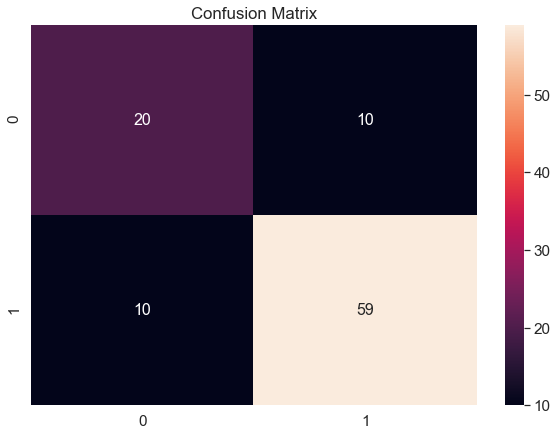

target variable:  Have you had a mental health disorder in the past?
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        30
           1       0.86      0.86      0.86        69

    accuracy                           0.80        99
   macro avg       0.76      0.76      0.76        99
weighted avg       0.80      0.80      0.80        99



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


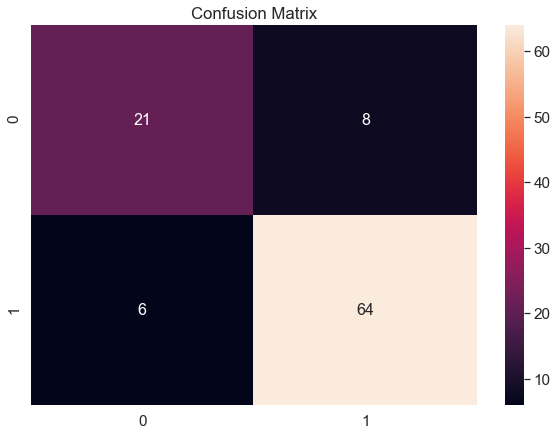

target variable:  Do you currently have a mental health disorder?
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        29
           1       0.89      0.91      0.90        70

    accuracy                           0.86        99
   macro avg       0.83      0.82      0.83        99
weighted avg       0.86      0.86      0.86        99



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


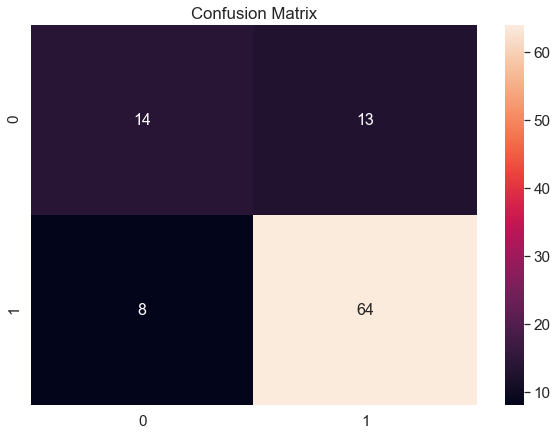

target variable:  Have you been diagnosed with a mental health condition by a medical professional?
              precision    recall  f1-score   support

           0       0.64      0.52      0.57        27
           1       0.83      0.89      0.86        72

    accuracy                           0.79        99
   macro avg       0.73      0.70      0.72        99
weighted avg       0.78      0.79      0.78        99



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


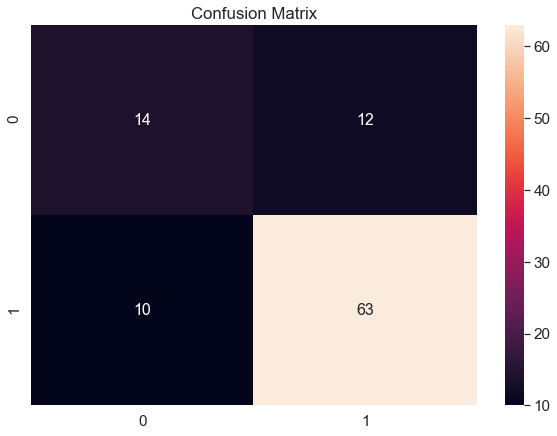

target variable:  Have you ever sought treatment for a mental health issue from a mental health professional?
              precision    recall  f1-score   support

           0       0.58      0.54      0.56        26
           1       0.84      0.86      0.85        73

    accuracy                           0.78        99
   macro avg       0.71      0.70      0.71        99
weighted avg       0.77      0.78      0.77        99



In [56]:
# EXCLUDING 'MAYBE'
# run Logistic Regression for each target variable
for target in y.columns:
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y[target], test_size=0.20)
    
    # LR model for target 
    logmodel = LogisticRegression()
    logmodel.fit(X_train,y_train)
    predictions = logmodel.predict(X_test)
    
    # print confusion matrix
    conf_mat = pd.DataFrame(confusion_matrix(y_test, predictions), range(2), range(2))
    plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(conf_mat, annot=True, annot_kws={"size": 16}) # font size
    plt.title('Confusion Matrix')
    plt.show()

    # accuracy for target 
    print("target variable: ", target)
    print(classification_report(y_test,predictions))

In [57]:
# EXPERIMENTING WITH NEURAL NETWORKS
# EXCLUDING 'MAYBE'

In [58]:
# EXCLUDING 'MAYBE'
# run NN without early stopping

for target in y.columns:
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y[target], test_size=0.20)
    
    nnmodel = Sequential()
    #First Hidden Layer
    nnmodel.add(Dense(10, activation='relu'))
    #Second  Hidden Layer
    nnmodel.add(Dense(4, activation='relu'))
    nnmodel.add(Dense(2, activation='relu'))
    #Output Layer
    nnmodel.add(Dense(1, activation='sigmoid'))

    nnmodel.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

    #Fitting the data to the training dataset
    nnmodel.fit(X_train.values,y_train.values, epochs=30)

    # accuracy for target 
    print("target variable: ", target)
    # evaluate model
    print("loss and accuracy: " + str(nnmodel.evaluate(X_test.values, y_test.values)) + "\n")

Epoch 1/30
392/392 [==============================] - 1s 3ms/step - loss: 0.7009 - accuracy: 0.5179
Epoch 2/30
392/392 [==============================] - 0s 116us/step - loss: 0.6024 - accuracy: 0.7449
Epoch 3/30
392/392 [==============================] - 0s 106us/step - loss: 0.5893 - accuracy: 0.7449
Epoch 4/30
392/392 [==============================] - 0s 105us/step - loss: 0.5853 - accuracy: 0.7449
Epoch 5/30
392/392 [==============================] - 0s 115us/step - loss: 0.5759 - accuracy: 0.7449
Epoch 6/30
392/392 [==============================] - 0s 114us/step - loss: 0.5574 - accuracy: 0.7449
Epoch 7/30
392/392 [==============================] - 0s 115us/step - loss: 0.5389 - accuracy: 0.7449
Epoch 8/30
392/392 [==============================] - 0s 111us/step - loss: 0.5138 - accuracy: 0.7449
Epoch 9/30
392/392 [==============================] - 0s 114us/step - loss: 0.5018 - accuracy: 0.7449
Epoch 10/30
392/392 [==============================] - 0s 121us/step - loss: 0.4865 

392/392 [==============================] - 0s 145us/step - loss: 0.6618 - accuracy: 0.6964
Epoch 18/30
392/392 [==============================] - 0s 144us/step - loss: 0.6603 - accuracy: 0.6964
Epoch 19/30
392/392 [==============================] - 0s 131us/step - loss: 0.6587 - accuracy: 0.6964
Epoch 20/30
392/392 [==============================] - 0s 129us/step - loss: 0.6573 - accuracy: 0.6964
Epoch 21/30
392/392 [==============================] - 0s 147us/step - loss: 0.6560 - accuracy: 0.6964
Epoch 22/30
392/392 [==============================] - 0s 159us/step - loss: 0.6545 - accuracy: 0.6964
Epoch 23/30
392/392 [==============================] - 0s 149us/step - loss: 0.6533 - accuracy: 0.6964
Epoch 24/30
392/392 [==============================] - 0s 151us/step - loss: 0.6519 - accuracy: 0.6964
Epoch 25/30
392/392 [==============================] - 0s 166us/step - loss: 0.6506 - accuracy: 0.6964
Epoch 26/30
392/392 [==============================] - 0s 145us/step - loss: 0.6494 -

In [59]:
# EXCLUDING 'MAYBE'
# run NN WITH early stopping

for target in y.columns:
    for i in range(1,5):
        # train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y[target], test_size=0.20)
    
        nnmodel = Sequential()
        #First Hidden Layer
        nnmodel.add(Dense(10, activation='relu'))
        #Second  Hidden Layer
        nnmodel.add(Dense(4, activation='relu'))
        nnmodel.add(Dense(2, activation='relu'))
        #Output Layer
        nnmodel.add(Dense(1, activation='sigmoid'))

        nnmodel.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

        #Fitting the data to the training dataset
        # patience for early stopping i=1,2,3,4..
        nnmodel.fit(X_train.values,y_train.values, epochs=30, validation_split = 0.2, callbacks=[EarlyStopping(monitor='val_loss', mode='auto', verbose=0, patience=i)])
        
        # patience
        print("patience: " + str(i))
        # accuracy for target 
        print("target variable: ", target)
        # evaluate model
        print("loss and accuracy: " + str(nnmodel.evaluate(X_test.values, y_test.values)) + "\n")

Train on 313 samples, validate on 79 samples
Epoch 1/30
313/313 [==============================] - 2s 5ms/step - loss: 0.6921 - accuracy: 0.6869 - val_loss: 0.6911 - val_accuracy: 0.7215
Epoch 2/30
313/313 [==============================] - 0s 154us/step - loss: 0.6898 - accuracy: 0.7508 - val_loss: 0.6890 - val_accuracy: 0.7215
Epoch 3/30
313/313 [==============================] - 0s 169us/step - loss: 0.6875 - accuracy: 0.7508 - val_loss: 0.6870 - val_accuracy: 0.7215
Epoch 4/30
313/313 [==============================] - 0s 157us/step - loss: 0.6852 - accuracy: 0.7508 - val_loss: 0.6850 - val_accuracy: 0.7215
Epoch 5/30
313/313 [==============================] - 0s 155us/step - loss: 0.6829 - accuracy: 0.7508 - val_loss: 0.6830 - val_accuracy: 0.7215
Epoch 6/30
313/313 [==============================] - 0s 157us/step - loss: 0.6806 - accuracy: 0.7508 - val_loss: 0.6810 - val_accuracy: 0.7215
Epoch 7/30
313/313 [==============================] - 0s 152us/step - loss: 0.6784 - accuracy

Epoch 26/30
313/313 [==============================] - 0s 158us/step - loss: 0.3860 - accuracy: 0.8530 - val_loss: 0.4307 - val_accuracy: 0.8228
patience: 2
target variable:  Have you had a mental health disorder in the past?
99/99 [==============================] - 0s 90us/step
loss and accuracy: [0.42580618521179814, 0.7979797720909119]

Train on 313 samples, validate on 79 samples
Epoch 1/30
313/313 [==============================] - 2s 5ms/step - loss: 0.6920 - accuracy: 0.6997 - val_loss: 0.6908 - val_accuracy: 0.7342
Epoch 2/30
313/313 [==============================] - 0s 193us/step - loss: 0.6897 - accuracy: 0.7380 - val_loss: 0.6886 - val_accuracy: 0.7342
Epoch 3/30
313/313 [==============================] - 0s 209us/step - loss: 0.6875 - accuracy: 0.7380 - val_loss: 0.6863 - val_accuracy: 0.7342
Epoch 4/30
313/313 [==============================] - 0s 213us/step - loss: 0.6852 - accuracy: 0.7380 - val_loss: 0.6841 - val_accuracy: 0.7342
Epoch 5/30
313/313 [===================

313/313 [==============================] - 0s 201us/step - loss: 0.4872 - accuracy: 0.7284 - val_loss: 0.4967 - val_accuracy: 0.7595
Epoch 24/30
313/313 [==============================] - 0s 259us/step - loss: 0.4802 - accuracy: 0.7284 - val_loss: 0.4925 - val_accuracy: 0.7595
Epoch 25/30
313/313 [==============================] - 0s 287us/step - loss: 0.4732 - accuracy: 0.7284 - val_loss: 0.4852 - val_accuracy: 0.7595
Epoch 26/30
313/313 [==============================] - 0s 338us/step - loss: 0.4662 - accuracy: 0.7284 - val_loss: 0.4825 - val_accuracy: 0.7595
Epoch 27/30
313/313 [==============================] - 0s 300us/step - loss: 0.4611 - accuracy: 0.7284 - val_loss: 0.4789 - val_accuracy: 0.7595
Epoch 28/30
313/313 [==============================] - 0s 279us/step - loss: 0.4543 - accuracy: 0.7284 - val_loss: 0.4713 - val_accuracy: 0.7595
Epoch 29/30
313/313 [==============================] - 0s 181us/step - loss: 0.4502 - accuracy: 0.7284 - val_loss: 0.4704 - val_accuracy: 0.75

313/313 [==============================] - 0s 131us/step - loss: 0.6573 - accuracy: 0.7604 - val_loss: 0.6541 - val_accuracy: 0.7975
Epoch 21/30
313/313 [==============================] - 0s 128us/step - loss: 0.6547 - accuracy: 0.7668 - val_loss: 0.6514 - val_accuracy: 0.8228
Epoch 22/30
313/313 [==============================] - 0s 132us/step - loss: 0.6526 - accuracy: 0.7668 - val_loss: 0.6493 - val_accuracy: 0.8228
Epoch 23/30
313/313 [==============================] - 0s 131us/step - loss: 0.6496 - accuracy: 0.7732 - val_loss: 0.6467 - val_accuracy: 0.8228
Epoch 24/30
313/313 [==============================] - 0s 130us/step - loss: 0.6473 - accuracy: 0.7827 - val_loss: 0.6442 - val_accuracy: 0.8354
Epoch 25/30
313/313 [==============================] - 0s 132us/step - loss: 0.6450 - accuracy: 0.7827 - val_loss: 0.6421 - val_accuracy: 0.8228
Epoch 26/30
313/313 [==============================] - 0s 130us/step - loss: 0.6418 - accuracy: 0.7827 - val_loss: 0.6396 - val_accuracy: 0.82

313/313 [==============================] - 0s 228us/step - loss: 0.6739 - accuracy: 0.6869 - val_loss: 0.6662 - val_accuracy: 0.7468
Epoch 14/30
313/313 [==============================] - 0s 198us/step - loss: 0.6726 - accuracy: 0.6869 - val_loss: 0.6644 - val_accuracy: 0.7468
Epoch 15/30
313/313 [==============================] - 0s 199us/step - loss: 0.6713 - accuracy: 0.6869 - val_loss: 0.6626 - val_accuracy: 0.7468
Epoch 16/30
313/313 [==============================] - 0s 198us/step - loss: 0.6700 - accuracy: 0.6869 - val_loss: 0.6610 - val_accuracy: 0.7468
Epoch 17/30
313/313 [==============================] - 0s 193us/step - loss: 0.6688 - accuracy: 0.6869 - val_loss: 0.6592 - val_accuracy: 0.7468
Epoch 18/30
313/313 [==============================] - 0s 214us/step - loss: 0.6676 - accuracy: 0.6869 - val_loss: 0.6574 - val_accuracy: 0.7468
Epoch 19/30
313/313 [==============================] - 0s 194us/step - loss: 0.6663 - accuracy: 0.6869 - val_loss: 0.6558 - val_accuracy: 0.74

313/313 [==============================] - 0s 162us/step - loss: 0.6075 - accuracy: 0.6997 - val_loss: 0.6316 - val_accuracy: 0.6709
Epoch 7/30
313/313 [==============================] - 0s 174us/step - loss: 0.5887 - accuracy: 0.6965 - val_loss: 0.6203 - val_accuracy: 0.6709
Epoch 8/30
313/313 [==============================] - 0s 165us/step - loss: 0.5851 - accuracy: 0.6997 - val_loss: 0.6154 - val_accuracy: 0.6962
Epoch 9/30
313/313 [==============================] - 0s 163us/step - loss: 0.5756 - accuracy: 0.6997 - val_loss: 0.6149 - val_accuracy: 0.6582
Epoch 10/30
313/313 [==============================] - 0s 168us/step - loss: 0.5633 - accuracy: 0.6933 - val_loss: 0.6107 - val_accuracy: 0.6582
Epoch 11/30
313/313 [==============================] - 0s 168us/step - loss: 0.5554 - accuracy: 0.7061 - val_loss: 0.6064 - val_accuracy: 0.6582
Epoch 12/30
313/313 [==============================] - 0s 163us/step - loss: 0.5468 - accuracy: 0.7157 - val_loss: 0.6026 - val_accuracy: 0.6582


Epoch 4/30
313/313 [==============================] - 0s 226us/step - loss: 0.6860 - accuracy: 0.7220 - val_loss: 0.6868 - val_accuracy: 0.6709
Epoch 5/30
313/313 [==============================] - 0s 189us/step - loss: 0.6839 - accuracy: 0.7220 - val_loss: 0.6853 - val_accuracy: 0.6709
Epoch 6/30
313/313 [==============================] - 0s 181us/step - loss: 0.6821 - accuracy: 0.7220 - val_loss: 0.6838 - val_accuracy: 0.6709
Epoch 7/30
313/313 [==============================] - 0s 193us/step - loss: 0.6800 - accuracy: 0.7220 - val_loss: 0.6824 - val_accuracy: 0.6709
Epoch 8/30
313/313 [==============================] - 0s 187us/step - loss: 0.6781 - accuracy: 0.7220 - val_loss: 0.6810 - val_accuracy: 0.6709
Epoch 9/30
313/313 [==============================] - 0s 178us/step - loss: 0.6763 - accuracy: 0.7220 - val_loss: 0.6795 - val_accuracy: 0.6709
Epoch 10/30
313/313 [==============================] - 0s 166us/step - loss: 0.6743 - accuracy: 0.7220 - val_loss: 0.6783 - val_accuracy

Epoch 23/30
313/313 [==============================] - 0s 221us/step - loss: 0.6466 - accuracy: 0.7508 - val_loss: 0.6412 - val_accuracy: 0.7722
Epoch 24/30
313/313 [==============================] - 0s 213us/step - loss: 0.6450 - accuracy: 0.7508 - val_loss: 0.6393 - val_accuracy: 0.7722
Epoch 25/30
313/313 [==============================] - 0s 220us/step - loss: 0.6433 - accuracy: 0.7508 - val_loss: 0.6375 - val_accuracy: 0.7722
Epoch 26/30
313/313 [==============================] - 0s 219us/step - loss: 0.6416 - accuracy: 0.7508 - val_loss: 0.6357 - val_accuracy: 0.7722
Epoch 27/30
313/313 [==============================] - 0s 229us/step - loss: 0.6400 - accuracy: 0.7508 - val_loss: 0.6339 - val_accuracy: 0.7722
Epoch 28/30
313/313 [==============================] - 0s 239us/step - loss: 0.6384 - accuracy: 0.7508 - val_loss: 0.6321 - val_accuracy: 0.7722
Epoch 29/30
313/313 [==============================] - 0s 238us/step - loss: 0.6369 - accuracy: 0.7508 - val_loss: 0.6303 - val_ac